In [10]:
# Import necessary libraries
import os
import zipfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt


In [11]:
# Read the CSV file with building metadata
metadata_df = pd.read_csv('building_polygons_metadata.csv')

# Display the first few rows to understand the structure
metadata_df.head()

# Filter for post-disaster images only
post_disaster_df = metadata_df[metadata_df['stage'] == 'post']

# Define disaster label mapping
disaster_labels = {
    'volcano': 1,
    'fire': 2,
    'tsunami': 3,
    'flooding': 4,
    'earthquake': 5,
    'wind': 6
}

post_disaster_df = (
    metadata_df.query("stage == 'post'")
    .assign(disaster_label=lambda x: x['disaster'].map(disaster_labels))
)

# Count images by disaster type
disaster_counts = post_disaster_df['disaster'].value_counts()
print("Post-disaster image counts by type:")
print(disaster_counts)


Post-disaster image counts by type:
disaster
flooding      38216
wind          36625
earthquake    32271
tsunami       31394
fire          23425
volcano         856
Name: count, dtype: int64


In [7]:
import os
from collections import Counter

def count_images_in_directory(directory_path):
    # Check if directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory '{directory_path}' not found.")
        return
    
    # Get all files in directory
    all_files = os.listdir(directory_path)
    
    # Count total files
    total_files = len(all_files)
    
    # Count by extension
    extensions = Counter([os.path.splitext(f)[1].lower() for f in all_files if os.path.isfile(os.path.join(directory_path, f))])
    
    # Count GAN-generated images (containing "_fake")
    gan_images = sum(1 for f in all_files if "_fake" in f and os.path.isfile(os.path.join(directory_path, f)))
    
    # Print results
    print(f"Directory: {directory_path}")
    print(f"Total files: {total_files}")
    print("\nBreakdown by extension:")
    for ext, count in extensions.most_common():
        if ext:  # Skip empty extensions
            print(f"  {ext}: {count}")
    
    print(f"\nGAN-generated images (containing '_fake'): {gan_images}")
    print(f"Regular images: {total_files - gan_images}")
    
    return total_files

# Example usage
image_dir = 'cropped_square_buildings_GAN'
count_images_in_directory(image_dir)

# Try to find other potential image directories
print("\nSearching for other potential image directories...")
for dir_name in os.listdir():
    if os.path.isdir(dir_name) and ("image" in dir_name.lower() or "build" in dir_name.lower() or "crop" in dir_name.lower()):
        if dir_name != image_dir:
            print(f"\nFound potential image directory: {dir_name}")
            count_images_in_directory(dir_name)


Directory: cropped_square_buildings_GAN
Total files: 240792

Breakdown by extension:
  .png: 240791

GAN-generated images (containing '_fake'): 1495
Regular images: 239297

Searching for other potential image directories...

Found potential image directory: cropped_buildings_subset
Directory: cropped_buildings_subset
Total files: 0

Breakdown by extension:

GAN-generated images (containing '_fake'): 0
Regular images: 0

Found potential image directory: cropped_buildings
Directory: cropped_buildings
Total files: 349

Breakdown by extension:
  .png: 348

GAN-generated images (containing '_fake'): 348
Regular images: 1


In [12]:
import os
import pandas as pd

# First, check if the directory exists and create it if needed
image_dir = 'cropped_square_buildings_GAN'
if not os.path.exists(image_dir):
    print(f"Warning: Directory '{image_dir}' not found. Creating it...")
    os.makedirs(image_dir, exist_ok=True)

# Check if there are any image files in the directory
files_in_dir = os.listdir(image_dir) if os.path.exists(image_dir) else []
if not files_in_dir:
    print(f"Warning: No files found in '{image_dir}'. Please ensure images are copied there.")

def find_image_paths(row):
    # Create a list to store paths
    paths = []
    
    # Check for regular image
    regular_filename = f"{row['uid']}_{row['stage']}.png"
    regular_path = os.path.join(image_dir, regular_filename)
    if os.path.isfile(regular_path):
        paths.append(regular_path)
    
    # Check for fake/GAN-generated image
    fake_filename = f"{row['uid']}_{row['stage']}_fake.png"
    fake_path = os.path.join(image_dir, fake_filename)
    if os.path.isfile(fake_path):
        paths.append(fake_path)
    
    return paths

# Generate image paths for all rows (returns a list of paths for each row)
post_disaster_df['image_paths'] = post_disaster_df.apply(find_image_paths, axis=1)

# Explode the dataframe so each image path gets its own row
# This converts a single row with multiple paths into multiple rows with one path each
expanded_df = post_disaster_df.explode('image_paths').reset_index(drop=True)

# Add a column to indicate if the image is fake
expanded_df['is_fake'] = expanded_df['image_paths'].apply(
    lambda x: '_fake.png' in str(x) if pd.notnull(x) else False
)

# Rename for clarity
expanded_df = expanded_df.rename(columns={'image_paths': 'image_path'})

# Keep only rows where the image path exists
valid_data_df = expanded_df[expanded_df['image_path'].notnull()]

print(f"Total post-disaster records (original): {len(post_disaster_df)}")
print(f"Total records after expansion: {len(expanded_df)}")
print(f"Valid post-disaster images found: {len(valid_data_df)}")
print(f"Real images: {len(valid_data_df[~valid_data_df['is_fake']])}")
print(f"GAN-generated images: {len(valid_data_df[valid_data_df['is_fake']])}")

# Optional: Show a few missing images for debugging
missing_uids = post_disaster_df[post_disaster_df['image_paths'].apply(len) == 0]['uid'].tolist()
if missing_uids:
    print(f"\nFound {len(missing_uids)} UIDs with no images (neither real nor fake):")
    for uid in missing_uids[:5]:  # Show first 5
        print(f"Missing: {uid}")
    
    # Additional debugging information
    print("\nCurrent working directory:", os.getcwd())
    print("Available directories and files:", os.listdir())


Total post-disaster records (original): 162787
Total records after expansion: 163506
Valid post-disaster images found: 118204
Real images: 117485
GAN-generated images: 719

Found 45302 UIDs with no images (neither real nor fake):
Missing: 425ae212-6733-4f5c-8382-997bec5d1497
Missing: f6762c00-8ebb-4c8d-a732-9b1c57581a33
Missing: aac05a0a-03e8-4f71-a1f3-f109abf2e88a
Missing: c659f61c-3abc-4df2-9ceb-9df69cbd5fa8
Missing: 7672395f-90c8-4a47-a46b-d48d001d03ec

Current working directory: /scratch/vpm2024/Project
Available directories and files: ['Resnet18_PostClassifierGAN.ipynb', 'best_subtype_model.pth', 'cropped_buildings_subset', 'validation_predictions.csv', 'building_polygons_metadata.csv', 'Resnet18_PostClassifier.ipynb', '.ipynb_checkpoints', 'requirements.txt', 'Resnet18_Damage.ipynb', 'subset', 'best_disaster_model.pth', 'cropped_buildings', 'ScratchWork.ipynb', 'best_disaster_model.h5', 'geotiffs', 'cropped_square_buildings_GAN', 'cropped_square_buildings', 'cropped_buildings.zip

In [13]:
# Find the minimum count of instances among all disaster types
min_count = valid_data_df['disaster'].value_counts().min()

# Create a balanced dataframe by sampling min_count instances from each disaster type
balanced_df = pd.DataFrame()
for disaster_type in valid_data_df['disaster'].unique():
    # Filter rows for this disaster type
    disaster_samples = valid_data_df[valid_data_df['disaster'] == disaster_type]
    
    # Sample min_count instances randomly
    if len(disaster_samples) > min_count:
        sampled = disaster_samples.sample(min_count, random_state=42)
    else:
        sampled = disaster_samples
    
    balanced_df = pd.concat([balanced_df, sampled])

# Reset index for the balanced dataframe
balanced_df = balanced_df.reset_index(drop=True)

# Show counts for verification
balanced_counts = balanced_df['disaster'].value_counts()

print(f"Balanced dataset size: {len(balanced_df)}")
print("Balanced counts per disaster type:")
print(balanced_counts)

# Replace valid_data_df with the balanced version
valid_data_df = balanced_df


Balanced dataset size: 4626
Balanced counts per disaster type:
disaster
wind          771
fire          771
flooding      771
tsunami       771
earthquake    771
volcano       771
Name: count, dtype: int64


In [14]:
disaster_counts = valid_data_df['subtype'].value_counts()
print(disaster_counts)

subtype
no-damage        3337
destroyed         422
minor-damage      331
major-damage      281
un-classified     255
Name: count, dtype: int64


Train set size: 3238
Validation set size: 694
Test set size: 694


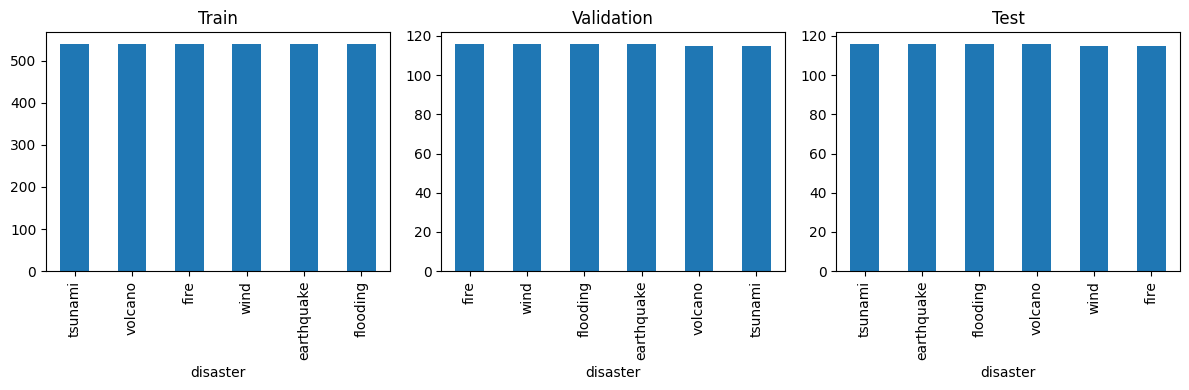

In [15]:
# Create data splits (70% train, 15% validation, 15% test)
train_df, temp_df = train_test_split(
    valid_data_df, 
    test_size=0.3, 
    random_state=42, 
    stratify=valid_data_df['disaster_label']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['disaster_label']
)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Visualize distribution of disaster types in each split
plt.figure(figsize=(12, 4))
train_df['disaster'].value_counts().plot(kind='bar', ax=plt.subplot(131), title='Train')
val_df['disaster'].value_counts().plot(kind='bar', ax=plt.subplot(132), title='Validation')
test_df['disaster'].value_counts().plot(kind='bar', ax=plt.subplot(133), title='Test')
plt.tight_layout()
plt.show()


In [16]:
# Custom dataset class for disaster images
class DisasterImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['disaster_label'] - 1  # Convert to 0-indexed
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = DisasterImageDataset(train_df, transform=train_transform)
val_dataset = DisasterImageDataset(val_df, transform=val_test_transform)
test_dataset = DisasterImageDataset(test_df, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)


In [ ]:
# Load pre-trained ResNet-18 model
try:
    # For newer PyTorch versions
    model = models.resnet50(weights='IMAGENET1K_V1')
except:
    # For older PyTorch versions
    model = models.resnet50(pretrained=True)

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)  # 6 disaster types

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.00001)


In [26]:
import os
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, save_path='best_disaster_model.pth'):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Ensure save_path is writable
    save_path = os.path.expanduser(save_path)
    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    # Outer epoch progress bar (leave=True keeps it on screen)
    epoch_pbar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch", leave=True)

    for epoch in epoch_pbar:
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Inner batch progress bar (leave=False so it disappears after each epoch)
        batch_pbar = tqdm(train_loader, 
                         desc=f'Epoch {epoch+1}/{num_epochs} [Training]',
                         leave=False,
                         unit="batch")
        for inputs, labels in batch_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            batch_pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{torch.sum(preds == labels.data).item()/inputs.size(0):.2%}"
            })

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        # Update the outer epoch bar with current stats
        epoch_pbar.set_postfix({
            'train_loss': f"{epoch_loss:.4f}",
            'train_acc': f"{epoch_acc:.2%}",
            'val_loss': f"{val_epoch_loss:.4f}",
            'val_acc': f"{val_epoch_acc:.2%}"
        })

        # Save best model with try/except
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            try:
                torch.save(model.state_dict(), save_path)
                tqdm.write(f"Model saved to {save_path} at epoch {epoch+1}")
            except Exception as e:
                tqdm.write(f"Warning: Could not save model at epoch {epoch+1}: {e}")

    tqdm.write("Training complete.")
    return model, history


In [29]:
from lightning.pytorch.utilities import disable_possible_user_warnings

# Ignore all warnings that could be false positives
disable_possible_user_warnings()

# Train the model
num_epochs = 50
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


ModuleNotFoundError: No module named 'lightning'

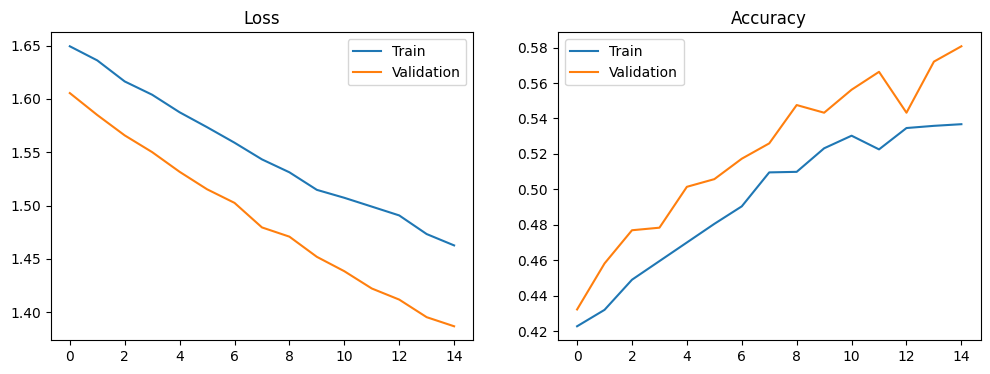

In [22]:
from tqdm.auto import tqdm

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.show()


Evaluating on test set:   0%|          | 0/22 [00:00<?, ?batch/s]

Test Accuracy: 0.5447


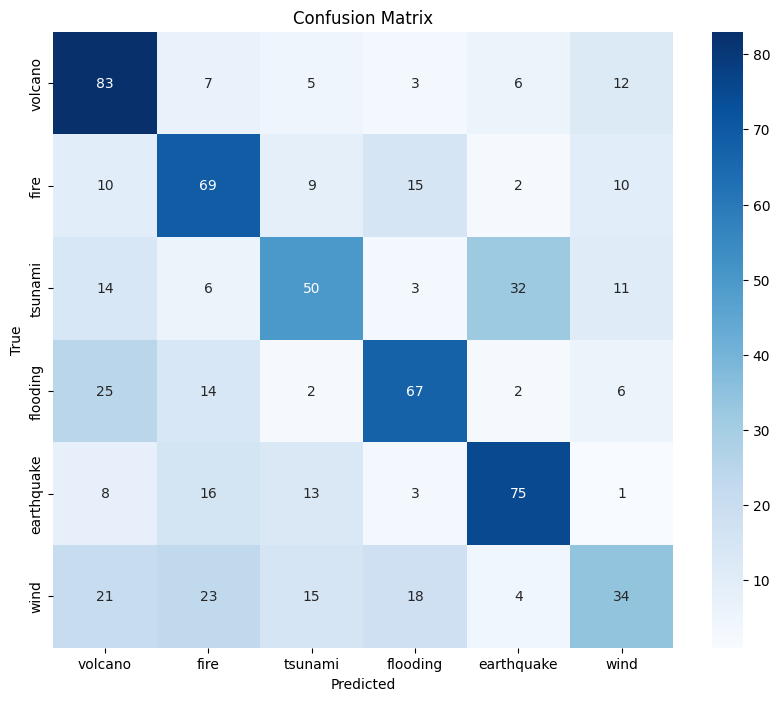

In [23]:

# Load the best model
model.load_state_dict(torch.load('best_disaster_model.pth'))

# Evaluate on test set with progress bar
def evaluate_model(model, test_loader):
    model.eval()
    test_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        # Add tqdm progress bar here
        for inputs, labels in tqdm(test_loader, desc="Evaluating on test set", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc:.4f}')
    
    return test_acc, all_preds, all_labels

# Run evaluation
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)

# Plot confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = list(disaster_labels.keys())
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
